In [1]:
## Python
#import module for predict
import os, glob
import numpy as np
import configparser
import cv2
from matplotlib import pyplot as plt
#Keras
from keras.models import model_from_json
from keras.models import Model
import keras.backend
#scikit learn
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
import sys
sys.path.insert(0, './lib/')
# help_functions.py
from help_functions import *
# extract_patches.py
from extract_patches import *
# pre_processing.py
from pre_processing import *

from keras.models import Model
from multi_scale_line import *


RESIZE_CONSTANT = 0.5


Using TensorFlow backend.
/home/bono/.pyenv/versions/3.5.5/envs/gpuTest/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bono/.pyenv/versions/3.5.5/envs/gpuTest/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bono/.pyenv/versions/3.5.5/envs/gpuTest/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np

In [2]:

import cv2
import numpy as np
import matplotlib.pyplot
def show_on_jupyter(img,color= None,title=None):
    import matplotlib.pyplot as plt
    import cv2
    """Show img on jupyter notebook. No return Value
    
    You should check the img's color space.
    I just consider about RGB color space & 1 ch color space(like green ch, gray space, ...)
    
    using matplotlib
    
    Parameters
    ----------
    img : 2-D Array
        numpy 2-D array
        opencv / sklearn / plt are avaliable.
        float / uint8 data type.
        
    color : string
        'gray' or 'None'
        'gray' means that img has a 1 ch.
        'None' means that img has a RGB ch.
        (default: None)
        
    title : string
        decide img's title
        (default : None)
        
    Returns
    -------
        No return value.
    
    Example
    -------
    >>> img = cv2.imread(img_path)
    >>> show_on_jupyter(img)
    
    img has a 1 ch
    >>> img = cv2.imread(img_path)
    >>> show_on_jupyter(img,'gray')
    """
    if color == 'gray':
        plt.axis("off")
        plt.title(title)
        plt.axis('off')
        plt.figure(figsize=(10, 10))
        plt.imshow(img,cmap=color)
        plt.show()
    elif color == None:
        plt.axis("off")
        plt.title(title)
        plt.axis('off')
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()
    else:
        print("Gray or None")


def load_data(data_path):
    
    imgs = np.empty((NUM_IMG,1,HEIGHT_IMG,WIDTH_IMG))
    cnt = 0
    for path, subdirs, files in os.walk(data_path): #list all files, directories in the path
        for i in range(len(files)):
            tempImg = Image.open(data_path + files[i])
            #print(files[i])
            #tempImg = np.asarray(tempImg)
            #print(tempImg.shape)
            w, h = tempImg.size
            print(w,h)
            print('w,h : ', w,'x',h)
            if (w == 700 and h ==380):
                print("Hi")
                tempImg = np.asarray(tempImg)
                tempImg = tempImg[np.newaxis,:,:]
                imgs[cnt] = tempImg
                cnt += 1
            
    return imgs

def group_plot(data,row,col):
    fig=plt.figure(figsize=(13, 13))
    columns = col
    rows = row
    for num in range(len(data)):
        img = data[num]
        fig.add_subplot(rows, columns, num+1)
        plt.imshow(img,cmap='gray')
    plt.show()

def get_conjunctivaData_testing(Conjunctiva_test_img_ori, num_test_img,patch_h, patch_w):
    
    # get img data
    test_img_ori = Conjunctiva_test_img_ori
    print(np.shape(test_img_ori))
    test_imgs = my_gray_preprocessing(test_img_ori)
    print(np.shape(test_img_ori))
    # extend both images and masks so they can be divided exactly by the patches dimensions
    # make tensor data.
    
    test_imgs = test_imgs[0:num_test_img,:,:,:]
    print('type : ',type(test_imgs))
    print('[get data testing func] prev test img shape : {} '.format(test_imgs.shape))
    test_imgs = paint_border(test_imgs,patch_h, patch_w)
    print('[get data testing func] after test img shape : {} '.format(test_imgs.shape))

    #data_consistency_check(test_imgs, test_grds)
    #assert(np.max(test_grds)==1  and np.min(test_grds)==0)
    
    print ("[get_data_testing_func] test images range (min-max): " +str(np.min(test_imgs)) +' - '+str(np.max(test_imgs)))
    print ("[get_data_testing_fucn] test masks are within 0-1\n")
    
    patches_imgs_test = extract_ordered(test_imgs,patch_h,patch_w)
    print ("\n[get_data_testing_fucn] test PATCHES images/grds shape:")
    print (patches_imgs_test.shape)
    print ("[get_data_testing_fucn] test PATCHES images range (min-max): {} - {}".format(str(np.min(patches_imgs_test)), str(np.max(patches_imgs_test))))
    
    return patches_imgs_test
    
    
def width_padding(img, pad_size):
    h,w = np.shape(img)
    #print('pad size', pad_size)
    
    if pad_size % 2 ==1: #odd number
        pad01 = np.zeros((h, pad_size//2))
        pad02 = np.zeros((h, pad_size//2 +1))
    
        result = np.hstack([pad01, img])
        result = np.hstack([result, pad02])
        
    else:
        pad01 = np.zeros((h, pad_size//2))
    
        result = np.hstack([pad01, img])
        result = np.hstack([result, pad01])
        
    print(np.shape(img), ' ',np.shape(result))
    return result
    
def height_padding(img,pad_size):
    h,w = np.shape(img)
    #print('pad size : ',pad_size)
    
    if pad_size % 2 ==1: #odd number
        pad01 = np.zeros((pad_size//2,w ))
        pad02 = np.zeros((pad_size//2 +1 , w))
        
        result = np.vstack([pad01, img])
        result = np.vstack([result,pad02])
        
    else:
        pad01 = np.zeros((pad_size//2, w))
    
        result = np.vstack([pad01, img])
        result = np.vstack([result, pad01])
    print(np.shape(img), ' ',np.shape(result))
    return result

    patches_imgs_test = extract_ordered(test_imgs,patch_h,patch_w)
    #data_consistency_check(test_imgs, test_grds)

    print ("\n[get_data_testing_fucn] test PATCHES images/grds shape:")
    print (patches_imgs_test.shape)
    print ("[get_data_testing_fucn] test PATCHES images range (min-max): {} - {}".format(str(np.min(patches_imgs_test)), str(np.max(patches_imgs_test))))

    return patches_imgs_test

def get_conjunctivaData_testing_overlap(Conjunctiva_test_img_ori, num_test_img,
                                        patch_h,patch_w,stride_h, stride_w):
    
    # get img data
    test_img_ori = Conjunctiva_test_img_ori
    print(np.shape(test_img_ori))
    test_imgs = my_gray_preprocessing(test_img_ori)
    #test_imgs = test_imgs/255.0
    
    # extend both images and masks so they can be divided exactly by the patches dimensions
    # make tensor data.
    
    test_imgs = test_imgs[0:num_test_img,:,:,:]
    
    #print('type : ',type(test_imgs))
    #print('[get data testing overlap] prev test img shape : {}  '.format(test_imgs.shape))
    test_imgs = paint_border_overlap(test_imgs,patch_h, patch_w,stride_h, stride_w)
    #test_grds = paint_border_overlap(test_grds, patch_h, patch_w,stride_h, stride_w)
    #print('[get data testing overlap] after test img shape : {}'.format(test_imgs.shape))
    
    print ("[get_data_testing_overlap func] test images range (min-max): " +str(np.min(test_imgs)) +' - '+str(np.max(test_imgs)))
    #print ("[get_data_testing_overlap fucn] test masks are within 0-1\n")
    
    patches_imgs_test = extract_ordered_overlap(test_imgs,patch_h,patch_w,stride_h,stride_w)
    
    #print ("\n[get_data_testing_overlap func] test PATCHES images shape:")
    print (patches_imgs_test.shape)
    #print ("[get_data_testing_overlap func] test PATCHES images range (min-max): " +str(np.min(patches_imgs_test)) +' - '+str(np.max(patches_imgs_test)))

    return patches_imgs_test, test_imgs.shape[2], test_imgs.shape[3]

## print(584 /64)
print(565/64)

## 여기부터 시작

In [3]:
#========= CONFIG FILE TO READ FROM =======
config = configparser.RawConfigParser()
config.read('conj_configuration.txt')

#run the training on invariant or local
path_data = config.get('test data path', 'conj_test_data')
path_ground_truth = config.get('data paths', 'conj_path_ground')

patch_height = int(config.get('data attributes', 'patch_height'))
patch_width = int(config.get('data attributes', 'patch_width'))

stride_height = int(config.get('testing settings', 'stride_height'))
stride_width = int(config.get('testing settings', 'stride_width'))

name_experiment = config.get('experiment name', 'name')

path_experiment = './' +'result/'+name_experiment
average_mode = config.getboolean('testing settings', 'average_mode')

# retina 
target_experiment = config.get('testing settings','experiment_target')

pretrain_path = config.get('fine tuning','pretrain path')

if config.get('fine tuning','fine_tuning') ==True:
    pretrained_dir = config.get('fine tuning', 'pretrained_dir')


if os.path.isdir(path_experiment) == False:
    os.mkdir(path_experiment)
else:
    print('already exist the folder in this path : {}'.format(path_experiment))

    
print(path_experiment)
print(pretrain_path)
print(name_experiment)
#print(target_experiment)

./result/201130/14_jmh/
./result/figure5/figure5_aug400000_batch16_lr_conjHrf/
201130/14_jmh/


In [4]:
filst = sorted(glob.glob('./'+name_experiment))
print(path_data)
print(patch_height)

./data/201130/proc_data/14_jmh/
64


In [5]:
# file order test

#case 01 : 2208_1848
#temp = cv2.imread('./data/20_04_16_gHos/2208_1848/5_imgs/sub_50_119_reg/00.png')


#print(np.shape(temp))
#temp = np.array((2208, 1848))
RESIZE_CONSTANT = 0.5
HEIGHT_IMG = int(1848 * RESIZE_CONSTANT) #(2054, 2456)
WIDTH_IMG = int(2208 *RESIZE_CONSTANT)
NUM_IMG = 0
CONJ_IMG_LIST = []

for count, filename in enumerate(sorted(os.listdir(path_data)), start=1):
    if filename.startswith(".ipynb")==False:
        #print('Enter {} to select {}'.format(count, filename))
        print(path_data,filename)
        tempImg = cv2.imread(path_data + filename,0)
        print(np.shape(tempImg))
        tempImg = cv2.resize(tempImg, (WIDTH_IMG, HEIGHT_IMG), interpolation = cv2.INTER_CUBIC)
        print(np.shape(tempImg))
        CONJ_IMG_LIST.append(tempImg)

        NUM_IMG = NUM_IMG +1
    
CONJ_IMG_LIST = np.asarray(CONJ_IMG_LIST)
print(np.shape(CONJ_IMG_LIST))
print(type(CONJ_IMG_LIST))

if os.path.isdir(path_experiment+str(RESIZE_CONSTANT)+'_test_imgs/') == False:
    os.mkdir(path_experiment+str(RESIZE_CONSTANT)+'_test_imgs/')
else:
    print('already exist the folder in this path : {}'.format(path_experiment+str(RESIZE_CONSTANT)+'_test_imgs/'))

for i in range(np.shape(CONJ_IMG_LIST)[0]):
    if i > 9:
        cv2.imwrite(path_experiment + str(RESIZE_CONSTANT) + '_test_imgs/'+str(i)+'.png',CONJ_IMG_LIST[i])
    else:
        cv2.imwrite(path_experiment +str(RESIZE_CONSTANT)+ '_test_imgs/0'+str(i)+'.png',CONJ_IMG_LIST[i])
        

./data/201130/proc_data/14_jmh/ 00.png
(1848, 2208)
(924, 1104)
./data/201130/proc_data/14_jmh/ 01.png
(1848, 2208)
(924, 1104)
./data/201130/proc_data/14_jmh/ 02.png
(1848, 2208)
(924, 1104)
./data/201130/proc_data/14_jmh/ 03.png
(1848, 2208)
(924, 1104)
./data/201130/proc_data/14_jmh/ 04.png
(1848, 2208)
(924, 1104)
./data/201130/proc_data/14_jmh/ 05.png
(1848, 2208)
(924, 1104)
./data/201130/proc_data/14_jmh/ 06.png
(1848, 2208)
(924, 1104)
./data/201130/proc_data/14_jmh/ 07.png
(1848, 2208)
(924, 1104)
./data/201130/proc_data/14_jmh/ 08.png
(1848, 2208)
(924, 1104)
./data/201130/proc_data/14_jmh/ 09.png
(1848, 2208)
(924, 1104)
./data/201130/proc_data/14_jmh/ 10.png
(1848, 2208)
(924, 1104)
./data/201130/proc_data/14_jmh/ 11.png
(1848, 2208)
(924, 1104)
./data/201130/proc_data/14_jmh/ 12.png
(1848, 2208)
(924, 1104)
./data/201130/proc_data/14_jmh/ 13.png
(1848, 2208)
(924, 1104)
./data/201130/proc_data/14_jmh/ 14.png
(1848, 2208)
(924, 1104)
./data/201130/proc_data/14_jmh/ 15.png
(

In [6]:
if os.path.isdir(path_experiment) == False:
    os.mkdir(path_experiment)
else:
    print('already exist the folder in this path : {}'.format(path_experiment))
path_experiment

already exist the folder in this path : ./result/201130/14_jmh/


'./result/201130/14_jmh/'

In [7]:
#conj_img = load_data(path_data) 
conj_img = np.expand_dims(CONJ_IMG_LIST,axis =1)

if average_mode == True:
    patches_conj_imgs_test, new_height, new_width = get_conjunctivaData_testing_overlap(conj_img,
                                                         NUM_IMG,
                                                         patch_height,
                                                         patch_width,
                                                         stride_height,
                                                        stride_width)
    conj_totimg = visualize(group_images(patches_conj_imgs_test[100:200,:,:,:]*255,2),path_experiment+'conj_overlap_test_patch_img')
else:
    patches_conj_imgs_test = get_conjunctivaData_testing(conj_img,
                                                         NUM_IMG,
                                                         patch_height,
                                                         patch_width)
    
    print(np.shape(patches_conj_imgs_test))
    conj_totimg = visualize(group_images(patches_conj_imgs_test[100:200,:,:,:]*255,2),path_experiment+'conj_test_patch_img')


(36, 1, 924, 1104)
[DEBUG preprocessing] :  (36, 1, 924, 1104)
new full images shape: 
(36, 1, 924, 1104)
[get_data_testing_overlap func] test images range (min-max): 0.0 - 1.0
extract , :  860 20 1040 20
[extrct_order_overlap func] Number of patches on h : 44
[extrct_order_overlap func] Number of patches on w : 53
[extrct_order_overlap func] number of patches per image: 2332 totally for this dataset: 83952
(83952, 1, 64, 64)
[group images func] prev data shape  : (100, 1, 64, 64)
[group images func] after data shape :  (100, 64, 64, 1)
[group images func] first total image :  (64, 128, 1)
[group images func] final total image :  (3264, 128, 1)
data shape :  (3264, 128, 1)
<PIL.Image.Image image mode=L size=128x3264 at 0x7F3EDC8A9FD0>
file name :  ./result/201130/14_jmh/conj_overlap_test_patch_img


In [8]:

#================ Run the prediction of the patches ==================================
best_last = config.get('testing settings', 'best_last')
#Load the saved model

inference_mode = config.get('testing settings', 'mode')
if inference_mode == 'conj':
    model = model_from_json(open(path_experiment +'_architecture.json').read())
    model.load_weights(path_experiment +best_last+'_weights.h5')
    
elif inference_mode == 'retina':
    model = model_from_json(open(pretrain_path +target_experiment+'_architecture.json').read())
    model.load_weights(pretrain_path +best_last+'_weights.h5')

In [9]:
conj_predictions = model.predict(patches_conj_imgs_test, batch_size=32, verbose=1)



83952/83952 [==============================] - 56s 670us/step


[group images func] prev data shape  : (50, 1, 64, 64)
[group images func] after data shape :  (50, 64, 64, 1)
[group images func] first total image :  (64, 128, 1)
[group images func] final total image :  (1664, 128, 1)
data shape :  (1664, 128, 1)
<PIL.Image.Image image mode=L size=128x1664 at 0x7F3EDC8A9198>
file name :  ./result/201130/14_jmh//predict_conj_patch_ori
[group images func] prev data shape  : (50, 1, 64, 64)
[group images func] after data shape :  (50, 64, 64, 1)
[group images func] first total image :  (64, 128, 1)
[group images func] final total image :  (1664, 128, 1)
data shape :  (1664, 128, 1)
<PIL.Image.Image image mode=L size=128x1664 at 0x7F3EDC8A95F8>
file name :  ./result/201130/14_jmh//predict_conj_patch_thresh


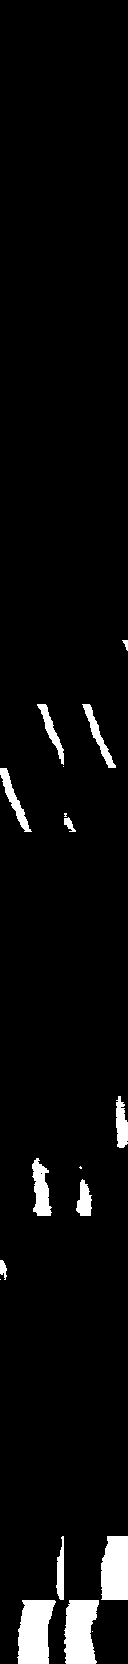

In [10]:
pred_conj_patches = pred_to_imgs(conj_predictions, patch_height, patch_width, "original") 
pred_conj_patches_thresh = pred_to_imgs(conj_predictions, patch_height, patch_width, "threshold") 


visualize(group_images(pred_conj_patches[150:200,:,:,:],2),path_experiment+'/predict_conj_patch_ori')
visualize(group_images(pred_conj_patches_thresh[150:200,:,:,:],2),path_experiment+'/predict_conj_patch_thresh')


In [11]:
if average_mode == True:
    conj_pred_imgs = recompose_overlap_img(pred_conj_patches, new_height, new_width, stride_height, stride_width)# predictions
    conj_pred_imgs_thr = recompose_overlap_img(pred_conj_patches_thresh, new_height, new_width, stride_height, stride_width)# predictions
    conj_ori_imgs = recompose_overlap_img(patches_conj_imgs_test,new_height, new_width, stride_height, stride_width)
   
    visualize(group_images(conj_pred_imgs[:,:,:,:],1),path_experiment+'/conj_predict_imgs')
    visualize(group_images(conj_pred_imgs_thr[:,:,:,:],1),path_experiment+'/conj_predict_thresh_imgs')
    visualize(group_images(conj_ori_imgs[:,:,:,:],1), path_experiment+'/conj_ori_imgs')


else:
    conj_pred_imgs = recompose_img(pred_conj_patches,33,39)
    conj_pred_imgs_thresh = recompose_img(pred_conj_patches_thresh,33,39)
    conj_ori_imgs = recompose_img(patches_conj_imgs_test,33,39)

    visualize(group_images(conj_pred_imgs[:,:,:,:],2),path_experiment+'/conj_predict_imgs')
    visualize(group_images(conj_pred_imgs_thresh[:,:,:,:],2),path_experiment+'/conj_predict_thresh_imgs')
    visualize(group_images(conj_ori_imgs[:,:,:,:],2), path_experiment+'/conj_ori_imgs')

full_img_height = conj_img.shape[2]
full_img_width = conj_img.shape[3]

N_patches_h: 44
N_patches_w: 53
N_patches_img: 2332
According to the dimension inserted, there are 36 full images (of 924x1104 each)
(36, 1, 924, 1104)
N_patches_h: 44
N_patches_w: 53
N_patches_img: 2332
According to the dimension inserted, there are 36 full images (of 924x1104 each)
(36, 1, 924, 1104)
N_patches_h: 44
N_patches_w: 53
N_patches_img: 2332
According to the dimension inserted, there are 36 full images (of 924x1104 each)
(36, 1, 924, 1104)
[group images func] prev data shape  : (36, 1, 924, 1104)
[group images func] after data shape :  (36, 924, 1104, 1)
[group images func] first total image :  (924, 1104, 1)
[group images func] final total image :  (34188, 1104, 1)
data shape :  (34188, 1104, 1)
<PIL.Image.Image image mode=L size=1104x34188 at 0x7F3DF1EABDD8>
file name :  ./result/201130/14_jmh//conj_predict_imgs
[group images func] prev data shape  : (36, 1, 924, 1104)
[group images func] after data shape :  (36, 924, 1104, 1)
[group images func] first total image :  (924

In [12]:
# make each prediction images


if average_mode == True:
    conj_pred_imgs = conj_pred_imgs[:,:,0:full_img_height,0:full_img_width]
    conj_pred_imgs_thr = conj_pred_imgs_thr[:,:,0:full_img_height,0:full_img_width]
    #conj_ori_imgs = gtruth_masks[:,:,0:full_img_height,0:full_img_width]
    
    print(np.shape(conj_pred_imgs_thr))

    if os.path.isdir(path_experiment + 'predicted_imgs') == False:
        os.mkdir(path_experiment + 'predicted_imgs')
    else:
        print('already exist the folder in this path : {}'.format(path_experiment + 'predicted_imgs'))

    temp_predicted_imgs = None

    for i in range(len(conj_pred_imgs_thr)):
        temp_predicted_imgs = conj_pred_imgs_thr[i,0,:,:] * 255
        temp_save_imgs = Image.fromarray(temp_predicted_imgs.astype(np.uint8))
        if i < 10:
            temp_save_imgs.save(path_experiment+'predicted_imgs/0'+str(i)+'_predict.png')
        else:
            temp_save_imgs.save(path_experiment+'predicted_imgs/'+str(i)+'_predict.png')


else:
    conj_pred_imgs = conj_pred_imgs[:,:,0:full_img_height,0:full_img_width]
    conj_pred_imgs_thresh = conj_pred_imgs_thresh[:,:,0:full_img_height,0:full_img_width]
    #conj_ori_imgs = gtruth_masks[:,:,0:full_img_height,0:full_img_width]
    
    print(np.shape(conj_pred_imgs_thresh))

    if os.path.isdir(path_experiment + 'predicted_imgs') == False:
        os.mkdir(path_experiment + 'predicted_imgs')
    else:
        print('already exist the folder in this path : {}'.format(path_experiment + 'predicted_imgs'))

    temp_predicted_imgs = None

    for i in range(len(conj_pred_imgs_thresh)):
        temp_predicted_imgs = conj_pred_imgs_thresh[i,0,:,:] * 255
        temp_save_imgs = Image.fromarray(temp_predicted_imgs.astype(np.uint8))
        if i <10:
            temp_save_imgs.save(path_experiment+'predicted_imgs/0'+str(i)+'_predict.png')
        else:
            temp_save_imgs.save(path_experiment+'predicted_imgs/'+str(i)+'_predict.png')


(36, 1, 924, 1104)


In [13]:
print(np.shape(conj_img))
print(np.shape(conj_pred_imgs))


(36, 1, 924, 1104)
(36, 1, 924, 1104)


In [14]:
path_experiment

'./result/201130/14_jmh/'